In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv
from numpy import genfromtxt
from math import pi
import os
import sodetlib.resonator_fitting as resfit
plt.ion()
plt.rcParams.update({'font.size': 22,'legend.fontsize': 16})
dirname = '/home/msilvafe/git_repos/readout-script-dev/Noise/'

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, facecolor='white') 

In [4]:
cd ../../

/home/msilvafe/git_repos/readout-script-dev/Noise


In [5]:
import Noise_Referral as nr

# Messy Scratch Space

This cell is iterating over all of the frequencies and getting the total loss, and 300K referred noise

Text(0.5, 0, 'Frequency [GHz]')

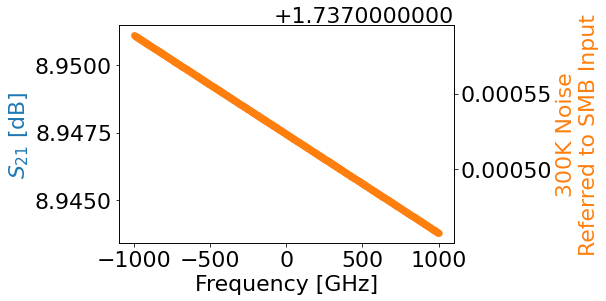

In [99]:
f_GHz = 4.370308
freqs = np.linspace(f_GHz - 1000e-6,f_GHz + 1000e-6,1000)
losstot = np.zeros(len(freqs))
T300vsFreq = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    lossin, Tavgin = nr.read_loss_in('./configs/','PicklesInputChain.csv',f)
    lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
    losstot[i] = np.sum(lossin)+np.sum(lossout)
    T300vsFreq[i] = nr.ref_noise_temp(lossin,Tavgin,290)
plt.plot((freqs-f_GHz)*1e6,-losstot,'C0.-',alpha = 0.5)
ax = plt.gca()
ax.set_ylabel('$S_{21}$ [dB]',color = 'C0')
ax2 = ax.twinx()
ax2.plot((freqs-f_GHz)*1e6,T300vsFreq,'C1o-',alpha = 0.5)
ax2.set_ylabel('300K Noise\nReferred to SMB Input',color = 'C1')
ax.set_xlabel('Frequency [GHz]')

This cell just prints stuff

In [100]:
f_GHz = 4.370308
kb = 1.380649e-23
lossin, Tavgin = nr.read_loss_in('./configs/','PicklesInputChain.csv',f_GHz)
lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f_GHz)
TNin, TNout = nr.Amp_Chain_Noise_Temp(lossout, Tavgout, LNA_TN)
print(f'3 LNA Noise Temps @ {f_GHz} GHz: {LNA_TN}\nNoise Temp Referred to Amp Chain Input: {np.round(TNin,2)} K',
      f'\nNoise Temp Referred to Amp Chain Output: {np.round(TNout,2)} K', 
      f'\nNoise Power Referred to Amp Chain Input {np.round(10*np.log10(kb*TNin/0.001),2)} dBm/Hz', 
      f'\nNoise Power Referred to Amp Chain Output {np.round(10*np.log10(kb*TNout/0.001),2)} dBm/Hz')

3 LNA Noise Temps @ 4.370308 GHz: [2.858087540956481, 18.882627920854464, 126.72880969880465]
Noise Temp Referred to Amp Chain Input: 3.68 K 
Noise Temp Referred to Amp Chain Output: 408365.24 K 
Noise Power Referred to Amp Chain Input -192.94 dBm/Hz 
Noise Power Referred to Amp Chain Output -142.49 dBm/Hz


This cell gets the resonator transfer function

In [86]:
dres = resfit.fit_tune('./MSF_scratch/External_Data_Inputs/1651275617_tune.npy')
outdat = resfit.resonator_cable(freqs*1e3,**dres[0][0]['model_params'])
plt.plot(freqs*1e3,np.abs(outdat))

This cell iterates over frequency and gets the amplifier chain noise referred to input for each frequency

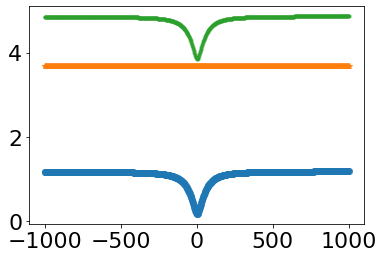

In [119]:
plt.plot((freqs-f_GHz)*1e6,T300vsFreq*np.abs(outdat),'C0o-',alpha = 0.5)
Amp_in = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
    TNin, TNout = nr.Amp_Chain_Noise_Temp(lossout, Tavgout, LNA_TN)
    Amp_in[i] = TNin
plt.plot((freqs-f_GHz)*1e6,Amp_in,'C1*',alpha = 0.5)
plt.plot((freqs-f_GHz)*1e6,Amp_in + T300vsFreq*np.abs(outdat),'C2.-',alpha = 0.5)

This cell loops over frequencies and gets the warm amp gain vs freq

In [104]:
roomtempampgain = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
    k = 0 
    for l in lossout:
        if l < 0:
            if k <= 1:
                k+=1
                continue
            if k>1:
                roomtempampgain[i] = -l

This cell gets the tone profile and noise with cable + amp terminated w/ a 50 Ohm datasets from the SA. Both datasets are referred back to before the cable and amp and then the reference noise data is subtracted from the tone profile. Then the tone profile is interpolated and referred down to the mux chip input.

(-175.0, -125.0)

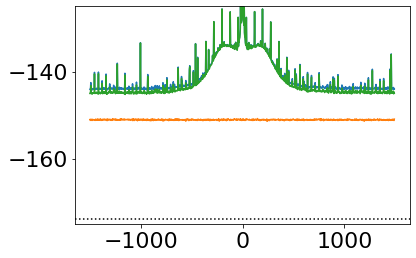

In [142]:
toneprof = np.load(open('./MSF_scratch/External_Data_Inputs/1652229111_data.npz','rb'))
cal = np.load(open('/home/msilvafe/Downloads/1652229306_data.npz','rb'))
c = pd.read_csv('/home/msilvafe/Downloads/Purple_Cable.csv',delimiter=',')
d2 = np.transpose(c.values)
pcbl_loss = np.interp(toneprof['freqs']/1e9,d2[0,:],d2[1,:])
amp_300k = np.interp(toneprof['freqs']/1e9,freqs,roomtempampgain)
# plt.plot((d['freqs']/1e9-f_GHz)*1e6,d['trace'])
plt.plot((d['freqs']/1e9-f_GHz)*1e6,d['trace']-pcbl_loss-amp_300k)
# plt.plot((cal['freqs']/1e9-f_GHz)*1e6,cal['trace'])
plt.plot((cal['freqs']/1e9-f_GHz)*1e6,cal['trace']-pcbl_loss-amp_300k)
dac_sub = d['trace']-pcbl_loss-amp_300k
cal_sub = cal['trace']-pcbl_loss-amp_300k
dac_diff_cal = 10**(dac_sub/10) - 10**(cal_sub/10)
plt.plot((cal['freqs']/1e9-f_GHz)*1e6,10*np.log10(dac_diff_cal))
# dac_noise_ref = np.zeros(len(freqs))
# # plt.xlim(-150,150)
# for i,f in enumerate(freqs):
#     lossin, Tavgin = nr.read_loss_in('./configs/','PicklesInputChain.csv',f)
#     lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
#     losstot[i] = np.sum(lossin)+np.sum(lossout)
#     TN = np.interp(f,cal['freqs']/1e9,dac_diff_cal*0.001/kb)
#     dac_noise_ref[i] = nr.ref_noise_temp(lossin,Tavgin,TN)
plt.axhline(-174,color = 'k',ls=':')
plt.ylim(-175,-125)

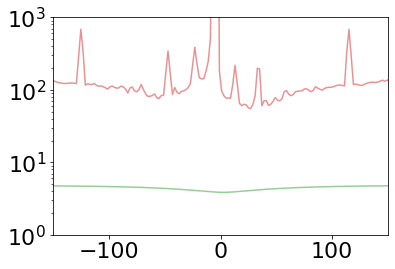

In [123]:
# plt.plot((freqs-f_GHz)*1e6,T300vsFreq*np.abs(outdat),'C0o-',alpha = 0.5)
# plt.plot((freqs-f_GHz)*1e6,Amp_in,'C1*',alpha = 0.5)
plt.plot((freqs-f_GHz)*1e6,Amp_in + T300vsFreq*np.abs(outdat),'C2',alpha = 0.5)
plt.plot((freqs-f_GHz)*1e6,Amp_in + (T300vsFreq + dac_noise_ref)*np.abs(outdat),'C3',alpha = 0.5)
plt.ylim(1,1000)
plt.xlim(-150,150)
plt.yscale('log')

# Clean it all up

In [115]:
# Set frequencies
f_GHz = 4.370308
kb = 1.380649e-23
freqs = np.linspace(f_GHz - 2000e-6,f_GHz + 2000e-6,1000)
t_pow = 0#-14.27

# Load required data
toneprof = np.load(open('./MSF_scratch/External_Data_Inputs/1652229111_data.npz','rb'))
cal = np.load(open('/home/msilvafe/Downloads/1652229306_data.npz','rb'))
out_compare = np.load(open('./MSF_scratch/External_Data_Inputs/1652285953_data.npz','rb'))
out_cal_tr = np.load(open('./MSF_scratch/External_Data_Inputs/1652229306_data.npz','rb'))
c = pd.read_csv('/home/msilvafe/Downloads/Purple_Cable.csv',delimiter=',')
d2 = np.transpose(c.values)
pcbl_loss = np.interp(freqs,d2[0,:],d2[1,:])
dres = resfit.fit_tune('./MSF_scratch/External_Data_Inputs/1652225982_tune.npy')
outdat = resfit.resonator_cable(freqs*1e3,**dres[0][52]['model_params'])*\
         resfit.resonator_cable(freqs*1e3,**dres[0][53]['model_params'])*\
         resfit.resonator_cable(freqs*1e3,**dres[0][54]['model_params'])

#Initialize some arrays
losstot = np.zeros(len(freqs))
T300vsFreq = np.zeros(len(freqs))
outgain = np.zeros(len(freqs))
Amp_in = np.zeros(len(freqs))
roomtempampgain = np.zeros(len(freqs))
dac_sub = np.zeros(len(freqs))
cal_sub = np.zeros(len(freqs))
dac_diff_cal = np.zeros(len(freqs))
dac_noise_ref = np.zeros(len(freqs))
dac_noise_ref_tail = np.zeros(len(freqs))
out_comp = np.zeros(len(freqs))
out_comp_cal = np.zeros(len(freqs))
out_cal = np.zeros(len(freqs))

#Loop over frequencies
for i,f in enumerate(freqs):
    lossin, Tavgin = nr.read_loss_in('./configs/','PicklesInputChain.csv',f)
    lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
    TNin, TNout = nr.Amp_Chain_Noise_Temp(lossout, Tavgout, LNA_TN)
    Amp_in[i] = TNin
    losstot[i] = np.sum(lossin)+np.sum(lossout)
    T300vsFreq[i] = nr.ref_noise_temp(lossin,Tavgin,290)
    outgain[i] = np.sum(lossout)
    k = 0 
    for l in lossout:
        if l < 0:
            if k <= 1:
                k+=1
                continue
            if k>1:
                roomtempampgain[i] = -l
    dac_sub[i] = np.interp(f,toneprof['freqs']/1e9,toneprof['trace']+t_pow)-pcbl_loss[i]-roomtempampgain[i]
    cal_sub[i] = np.interp(f,cal['freqs']/1e9,cal['trace']+t_pow)-pcbl_loss[i]-roomtempampgain[i]
    dac_diff_cal[i] = 10**(dac_sub[i]/10) - 10**(cal_sub[i]/10)
    dac_sub_tail = np.interp(4.369,toneprof['freqs']/1e9,toneprof['trace']+t_pow)-pcbl_loss[i]-roomtempampgain[i]
    cal_sub_tail = np.interp(4.369,cal['freqs']/1e9,cal['trace']+t_pow)-pcbl_loss[i]-roomtempampgain[i]
    dac_diff_cal_tail = 10**(dac_sub_tail/10) - 10**(cal_sub_tail/10)
    dac_noise_ref[i] = nr.ref_noise_temp(lossin,Tavgin,dac_diff_cal[i]*0.001/kb)
    dac_noise_ref_tail[i] = nr.ref_noise_temp(lossin,Tavgin,dac_diff_cal_tail*0.001/kb)
    out_cal[i] = np.interp(f,out_cal_tr['freqs']/1e9,out_cal_tr['trace']+t_pow)-roomtempampgain[i]
    out_comp[i] = np.interp(f,out_compare['freqs']/1e9,out_compare['trace']+t_pow)-roomtempampgain[i]
    out_comp_cal[i] = 10**(out_comp[i]/10) - 10**(cal_sub[i]/10)

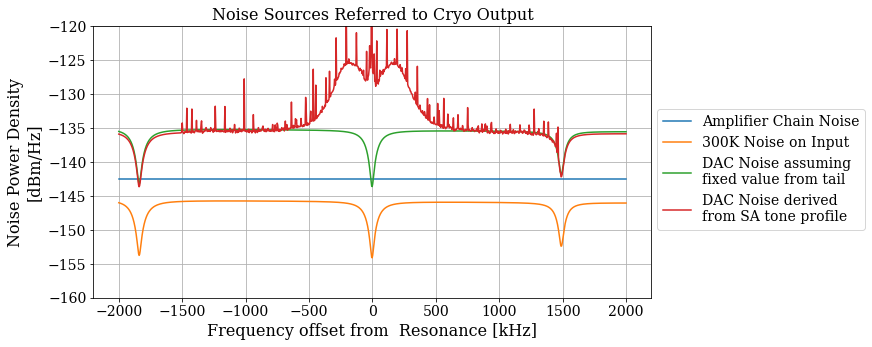

In [105]:
plt.figure(figsize = (10,5))
normfact = np.abs(outdat)/np.max(np.abs(outdat))
plt.plot((freqs-f_GHz)*1e6, -outgain + 10*np.log10(Amp_in*kb/1e-3),label = 'Amplifier Chain Noise')
plt.plot((freqs-f_GHz)*1e6, -outgain + 10*np.log10(T300vsFreq*normfact*kb/1e-3),label = '300K Noise on Input')
plt.plot((freqs-f_GHz)*1e6, -outgain + 10*np.log10(dac_noise_ref_tail*normfact*kb/1e-3),label = 'DAC Noise assuming\nfixed value from tail')
plt.plot((freqs-f_GHz)*1e6, -outgain + 10*np.log10(dac_noise_ref*normfact*kb/1e-3),label = 'DAC Noise derived\nfrom SA tone profile')
plt.legend(loc = (1.01,0.25))
plt.ylim(-160,-120)
plt.yticks([-160,-155,-150,-145,-140,-135,-130,-125,-120])
plt.xlabel('Frequency offset from  Resonance [kHz]')
plt.ylabel('Noise Power Density\n[dBm/Hz]')
plt.title('Noise Sources Referred to Cryo Output')
plt.grid()

# Compare Measured Output to Predicted

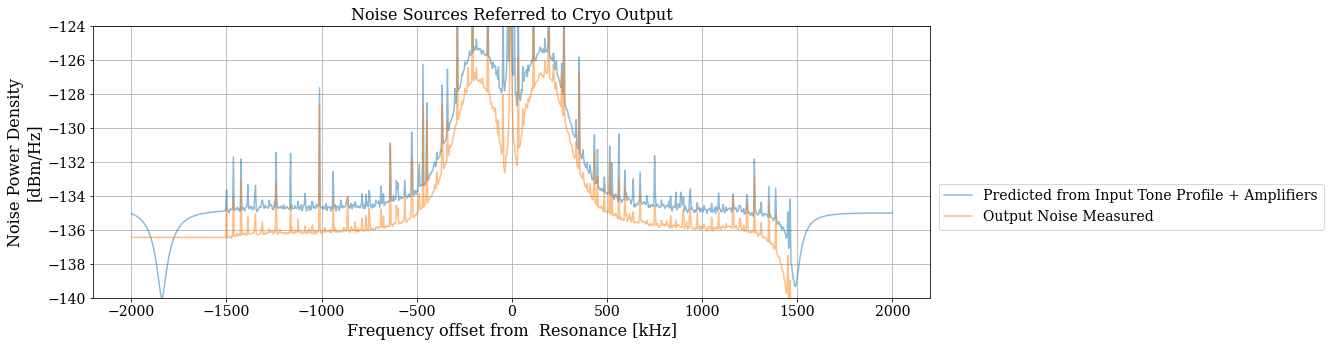

In [132]:
plt.figure(figsize = (15,5))
amp_n = 0.001*10**((-outgain + 10*np.log10(Amp_in*kb/1e-3))/10)
DAC_n = 0.001*10**((-outgain + 10*np.log10(dac_noise_ref*normfact*kb/1e-3))/10)
tot_n = amp_n + DAC_n

# plt.plot((freqs-f_GHz)*1e6, -outgain + 10*np.log10(Amp_in*kb/1e-3),label = 'Amplifier Chain Noise',alpha = 0.5)
# plt.plot((freqs-f_GHz)*1e6, -outgain + 10*np.log10(dac_noise_ref*normfact*kb/1e-3),label = 'DAC Noise derived\nfrom SA tone profile',alpha = 0.5)
plt.plot((freqs-f_GHz)*1e6, 10*np.log10(tot_n/1e-3), label =  'Predicted from Input Tone Profile + Amplifiers',alpha = 0.5)

plt.plot((freqs-f_GHz)*1e6, 10*np.log10(out_comp_cal),label = 'Output Noise Measured',alpha = 0.5)

plt.legend(loc = (1.01,0.25))
plt.ylim(-140,-124)
# plt.yticks([-155,-150,-145,-140,-135,-130])
plt.xlabel('Frequency offset from  Resonance [kHz]')
plt.ylabel('Noise Power Density\n[dBm/Hz]')
plt.title('Noise Sources Referred to Cryo Output')
plt.grid()

# Look at single sided phase noise
Getting powers right here is a bit fishy...definitely need to redo this more carefully.

Power at Feedline:  -75.71736300623738 dB
-24.430758637213074 -26.825014403211192


(-120.0, -90.0)

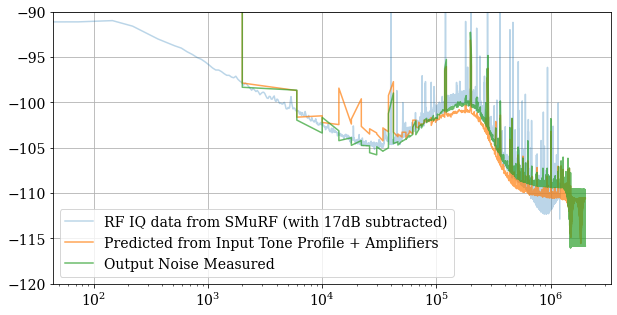

In [233]:
f = 4.3703
lossin, Tavgin = nr.read_loss_in('./configs/','PicklesInputChain.csv',f)
lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
sideband = np.load('./MSF_scratch/External_Data_Inputs/IQ_dBc_Old_LO.npy',allow_pickle=True).item()
for l in lossout:
    if l < 0:
        if k <= 1:
            k+=1
            continue
        if k>1:
            roomtempampgain = -l
outgain = np.sum(lossout[:-2])
P_feed = nr.p_referred_pertone(lossin,-14.27-roomtempampgain-pcbl_loss[np.argmin(np.abs(freqs-f))],True)
P_out = P_feed - outgain

idx_max = np.argmin(tot_n)
f_GHz = freqs[idx_max]
f_GHz = 4.370308 - 2*np.mean(np.diff(freqs))
idx_ordered = np.argsort(np.abs((freqs-f_GHz)*1e9))
f_ordered = np.sort(np.abs((freqs-f_GHz)*1e9))
P_meas = -21.96 - roomtempampgain + 16
print(P_out,P_meas)

plt.figure(figsize = (10,5))
plt.semilogx(sideband[1]['ffi'],10*np.log10(sideband[1]['pxxi']/sideband[1]['magfac'])-17,alpha = 0.3, label = 'RF IQ data from SMuRF (with 17dB subtracted)')
plt.semilogx(f_ordered, 10*np.log10(tot_n[idx_ordered]/1e-3) - P_out, label =  'Predicted from Input Tone Profile + Amplifiers',alpha = 0.7)
plt.semilogx(f_ordered, 10*np.log10(out_comp_cal[idx_ordered]) - P_meas,label = 'Output Noise Measured',alpha = 0.7)

plt.legend()
plt.grid()
plt.ylim(-120,-90)

# Resonator TF

Text(0, 0.5, '$S_{21}$')

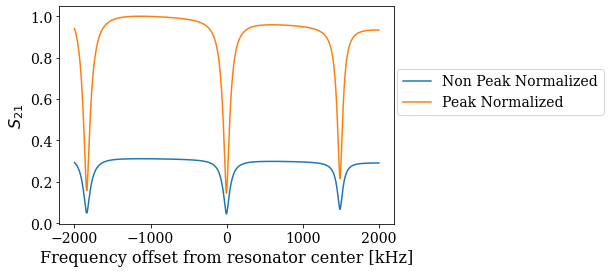

In [273]:
plt.plot((freqs-f_GHz)*1e6, np.abs(outdat),label = 'Non Peak Normalized')
plt.plot((freqs-f_GHz)*1e6, np.abs(outdat)/np.max(np.abs(outdat)),label = 'Peak Normalized')
plt.legend(loc = (1.01,0.5))
plt.xlabel('Frequency offset from resonator center [kHz]')
plt.ylabel('$S_{21}$')

# Compare my Calculated Transmission to Shawn's Measurements

In [233]:
import skrf as rf

In [238]:
# Set frequencies
freqs2 = np.linspace(4,8,1000)
losstot2 = np.zeros(len(freqs))
for i,f in enumerate(freqs2):
    lossin, Tavgin = nr.read_loss_in('./configs/','PicklesInputChain.csv',f)
    lossout, Tavgout, LNA_TN = nr.read_loss_out('./configs/','PicklesOutputChain.csv',f)
    # Start sum at first index bc the VNA measurement has 10ft cbls calibrated out.
    losstot2[i] = np.sum(lossin[1:])+np.sum(lossout[:-1])

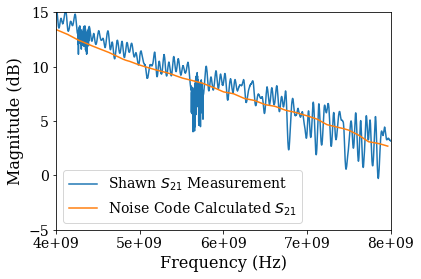

In [239]:
net = rf.Network('/home/msilvafe/Downloads/20220510_RFCHAIN1_RUN15_NEWCAL_10MHz_to_20GHz_LORES.s2p')
net.plot_s_db(1,0)
plt.xlim(4e9,8e9)
plt.ylim(-5,15)
plt.plot(freqs2*1e9,-losstot2)
plt.legend(['Shawn $S_{21}$ Measurement', 'Noise Code Calculated $S_{21}$'])

In [245]:
dres = resfit.fit_tune('./MSF_scratch/External_Data_Inputs/1652225982_tune.npy')
outdat1 = resfit.resonator_cable(freqs*1e3,**dres[0][0]['model_params'])

In [255]:
fit_freqs = [dres[0][k]['model_params']['f_0'] for k in range(64)]
fit_freqs = np.asarray(fit_freqs)
np.argmin(np.abs(fit_freqs - 4370.3))

53

In [257]:
for k in [52,53,54]:
    print(dres[0][k]['model_params'])

{'f_0': 4368.464467932653, 'Q': 26291.068003259512, 'Q_e_real': 30953.692785466425, 'Q_e_imag': -1796.007779210806, 'delay': 0.024762765061929395, 'phi': 2.658409328565674, 'f_min': 4368.187566870631, 'A_mag': 0.6583213101592073, 'A_slope': 0.0022932954957942614}
{'f_0': 4370.30375955604, 'Q': 28341.122629193786, 'Q_e_real': 33229.550163270615, 'Q_e_imag': -511.2829708941281, 'delay': 0.029192480130039607, 'phi': 2.775339174911887, 'f_min': 4369.457252393468, 'A_mag': 0.6794493624416867, 'A_slope': -0.011458719457050742}
{'f_0': 4371.798229300613, 'Q': 35399.25095811249, 'Q_e_real': 45730.901266669825, 'Q_e_imag': 922.531930482015, 'delay': 0.01706884137251958, 'phi': 2.750067776131854, 'f_min': 4370.455383534962, 'A_mag': 0.6907752214918111, 'A_slope': -0.014700594189497485}
